# (27) vH — xtract 100

**Motivation**: Extract $100 \times 100$ random patches from vH16. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from figures.imgs import plot_weights
from utils.imgproc import (
    do_process, xtract_patches_random,
    do_fft, compute_fftfreq,
    EyeDataset,
)

### Load dataset

In [3]:
doves = EyeDataset()
doves.imgs.shape

torch.Size([101, 1, 768, 1024])

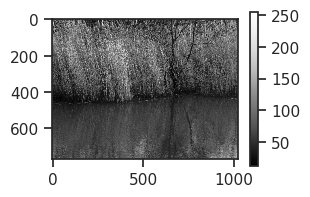

In [4]:
imshow(doves.imgs[67], cmap='Greys_r')
plt.colorbar();

In [5]:
ds = torch.utils.data.TensorDataset(doves.imgs)

In [16]:
patches = xtract_patches_random(
    dataset=ds,
    npix=100,
    n_patches=20,
    # batch_size=101,
)

In [17]:
patches.shape

torch.Size([2020, 1, 100, 100])

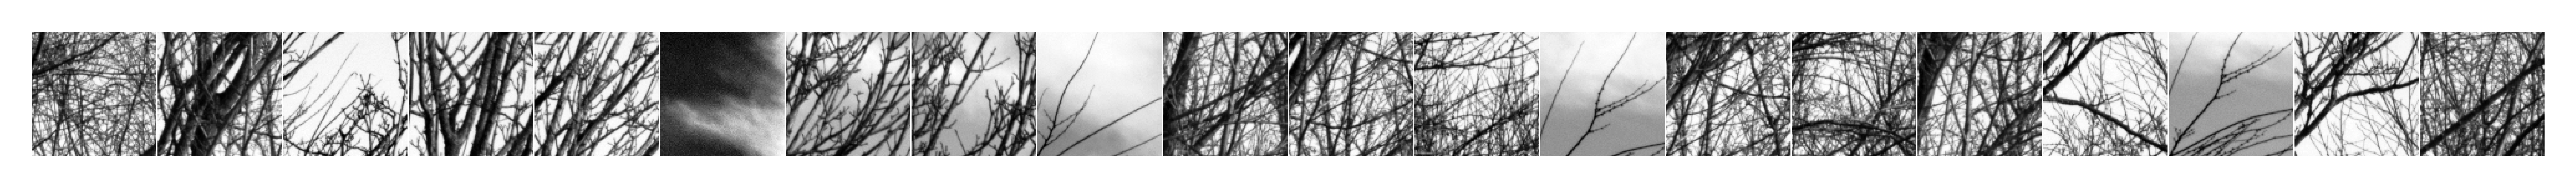

In [19]:
plot_weights(patches[:20].squeeze(), nrows=1, dpi=1000);

In [20]:
x = patches
x.shape

torch.Size([2020, 1, 100, 100])

In [83]:
def subsample_img(x, grid_size=16, spacing=3, delta_x=0, delta_y=0):
    spacing = int(max(0, spacing))
    size = spacing * (grid_size - 1) + grid_size

    b, _, h, w = x.shape
    center_x = w // 2 + delta_x
    center_y = h // 2 + delta_y
    
    x0 = center_x - size // 2
    y0 = center_y - size // 2

    inds = torch.arange(start=0, end=size, step=spacing + 1)
    xx, yy = torch.meshgrid(inds + x0, inds + y0, indexing='xy')
    sampled_img = x[..., yy, xx]
    return sampled_img

In [89]:
sampled_img = subsample_img(patches, grid_size=16, spacing=2)
sampled_img.shape

torch.Size([2020, 1, 16, 16])

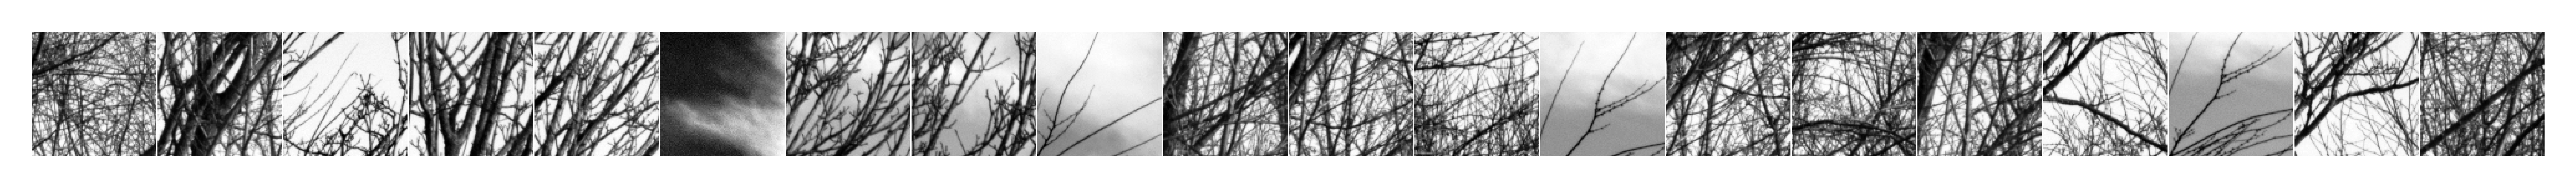

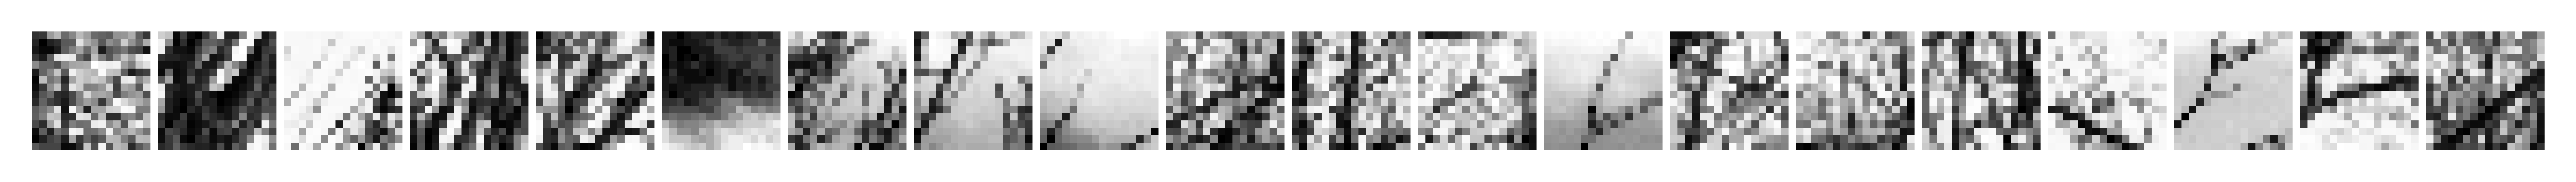

In [90]:
plot_weights(patches[:20].squeeze(), nrows=1, dpi=1000);
plot_weights(sampled_img[:20].squeeze(), nrows=1, dpi=1000);

In [6]:

load_dir = '/home/hadi/Datasets/DOVES'
os.listdir(load_dir)

['vHimgs.h5', 'data1024.h5', 'data1040.h5', 'vH16']

### Xtract patches

In [4]:
%%time

patches = {
    k: xtract_patches_random(
        dataset=ds,
        npix=20,
        n_patches=4,
    ) for k, ds in dataset.items()
}

CPU times: user 15.7 s, sys: 528 ms, total: 16.3 s
Wall time: 9.45 s


In [5]:
print({k: v.shape for k, v in patches.items()})

{'trn': torch.Size([200000, 1, 20, 20]), 'vld': torch.Size([40000, 1, 20, 20])}

### Whiten + Contrans nrm + Zscore

In [6]:
%%time

processed = {
    k: do_process(
        stim=x.cuda(),
        crop_size=2,
    ) for k, x in patches.items()
}

CPU times: user 5.36 s, sys: 308 ms, total: 5.67 s
Wall time: 665 ms


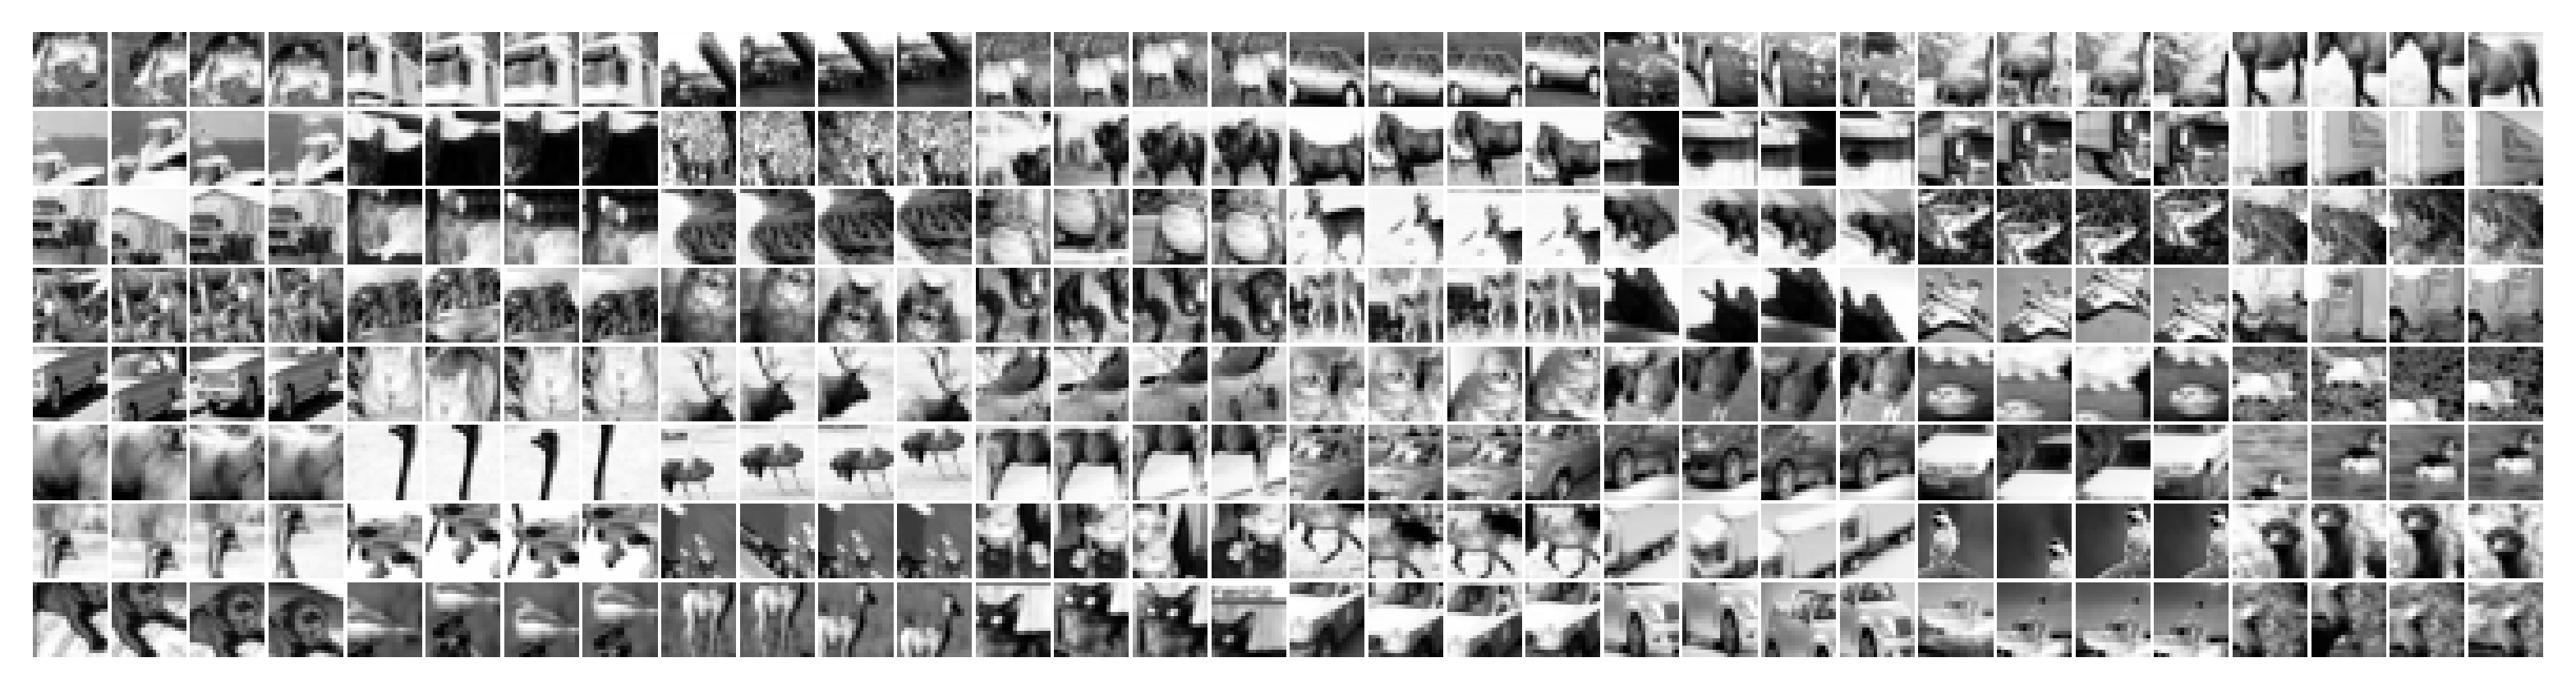

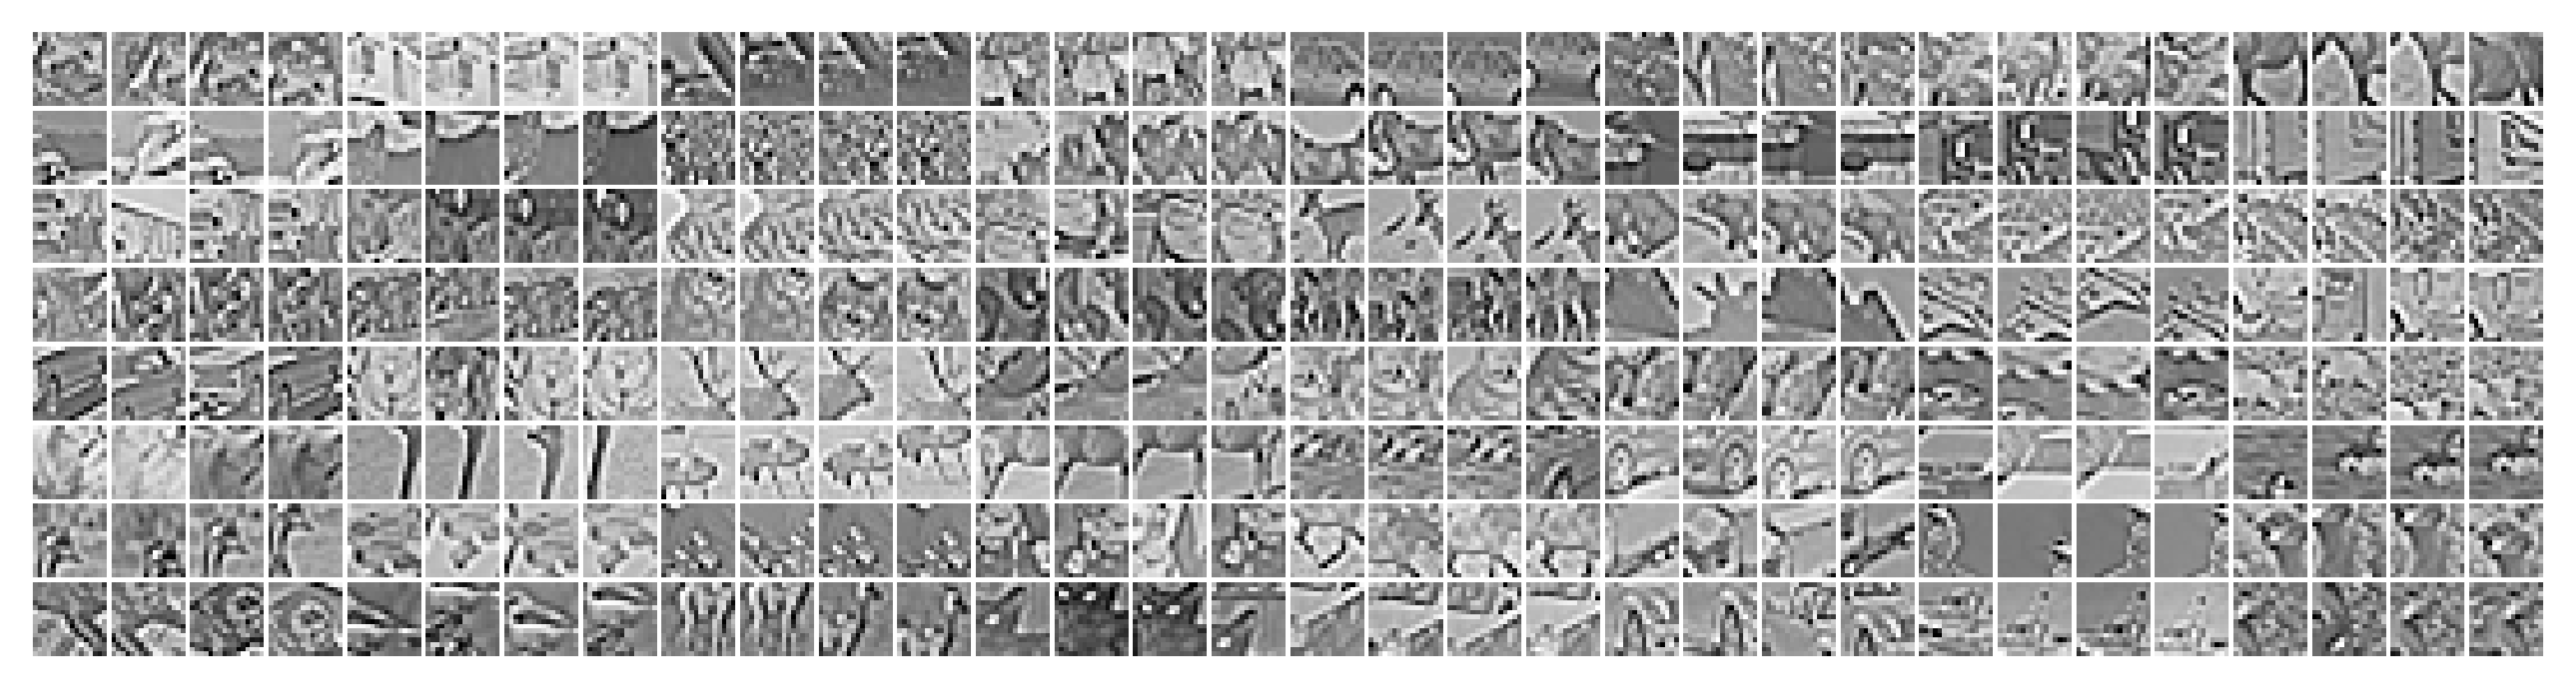

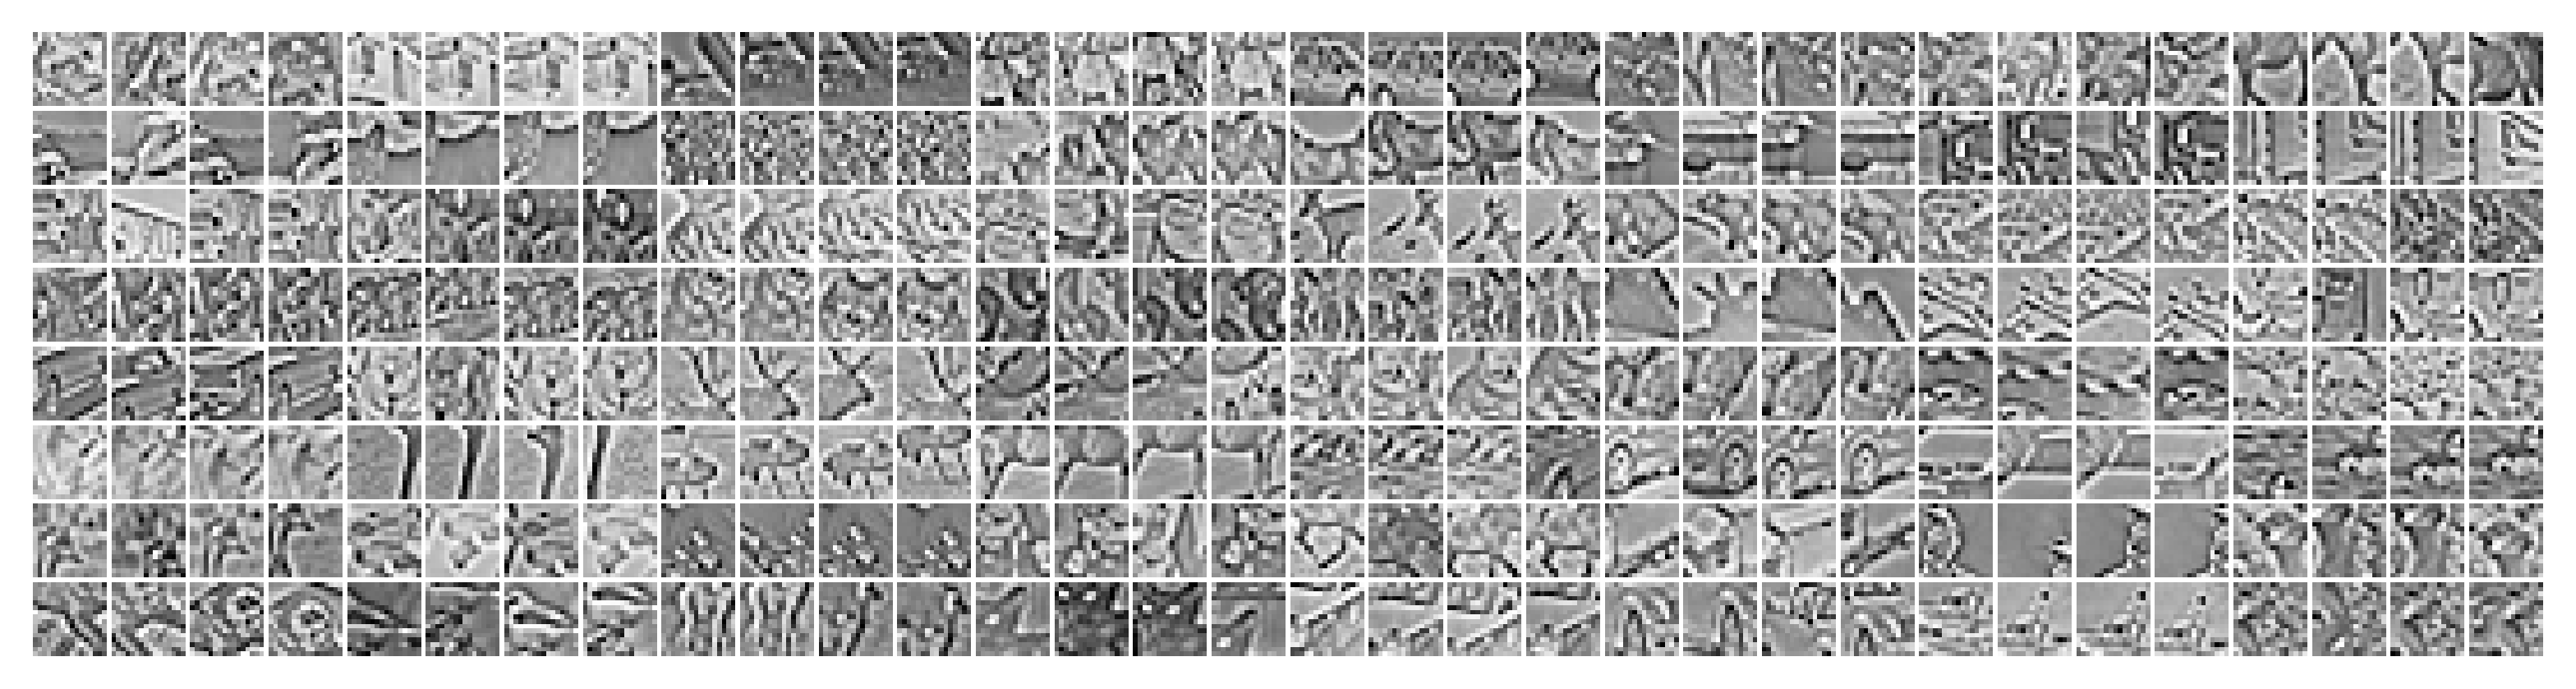

In [7]:
_ = plot_weights(patches['trn'].squeeze()[:256], nrows=8, dpi=400)
_ = plot_weights(processed['trn'][0].squeeze()[:256], nrows=8, dpi=400)
_ = plot_weights(processed['trn'][2].squeeze()[:256], nrows=8, dpi=400)

In [8]:
processed['trn'][2].shape

torch.Size([200000, 1, 16, 16])

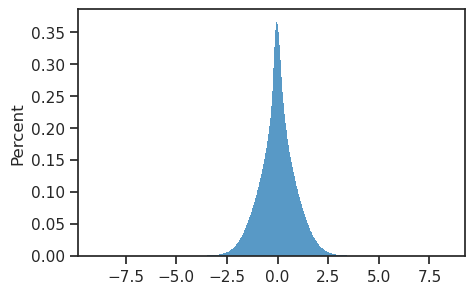

In [10]:
sns.histplot(to_np(processed['trn'][2]).ravel(), stat='percent');

## Save

In [11]:
path = '/home/hadi/Datasets/CIFAR10'
path = pjoin(path, 'xtract16')

for k, items in processed.items():
    save_dir = pjoin(path, k)
    os.makedirs(save_dir, exist_ok=True)
    
    save_dict = {
        'patches': to_np(patches[k]),
        'wt': to_np(items[0]),
        'wt_cn': to_np(items[1]),
        'processed': to_np(items[2]),
    }
    for fname, obj in save_dict.items():
        save_obj(
            obj=obj,
            file_name=fname,
            save_dir=save_dir,
            verbose=True,
            mode='npy',
        )

[PROGRESS] 'patches.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/trn

[PROGRESS] 'wt.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/trn

[PROGRESS] 'wt_cn.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/trn

[PROGRESS] 'processed.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/trn

[PROGRESS] 'patches.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/vld

[PROGRESS] 'wt.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/vld

[PROGRESS] 'wt_cn.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/vld

[PROGRESS] 'processed.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/vld

In [12]:
to_np(patches['trn']).dtype, to_np(processed['trn'][2]).dtype

(dtype('float32'), dtype('float32'))

## Try loading (after saving is done above)

In [13]:
trn, vld = make_dataset(
    dataset='CIFAR10_PATCHES',
    load_dir='/home/hadi/Datasets',
    device=torch.device('cuda:0'),
)

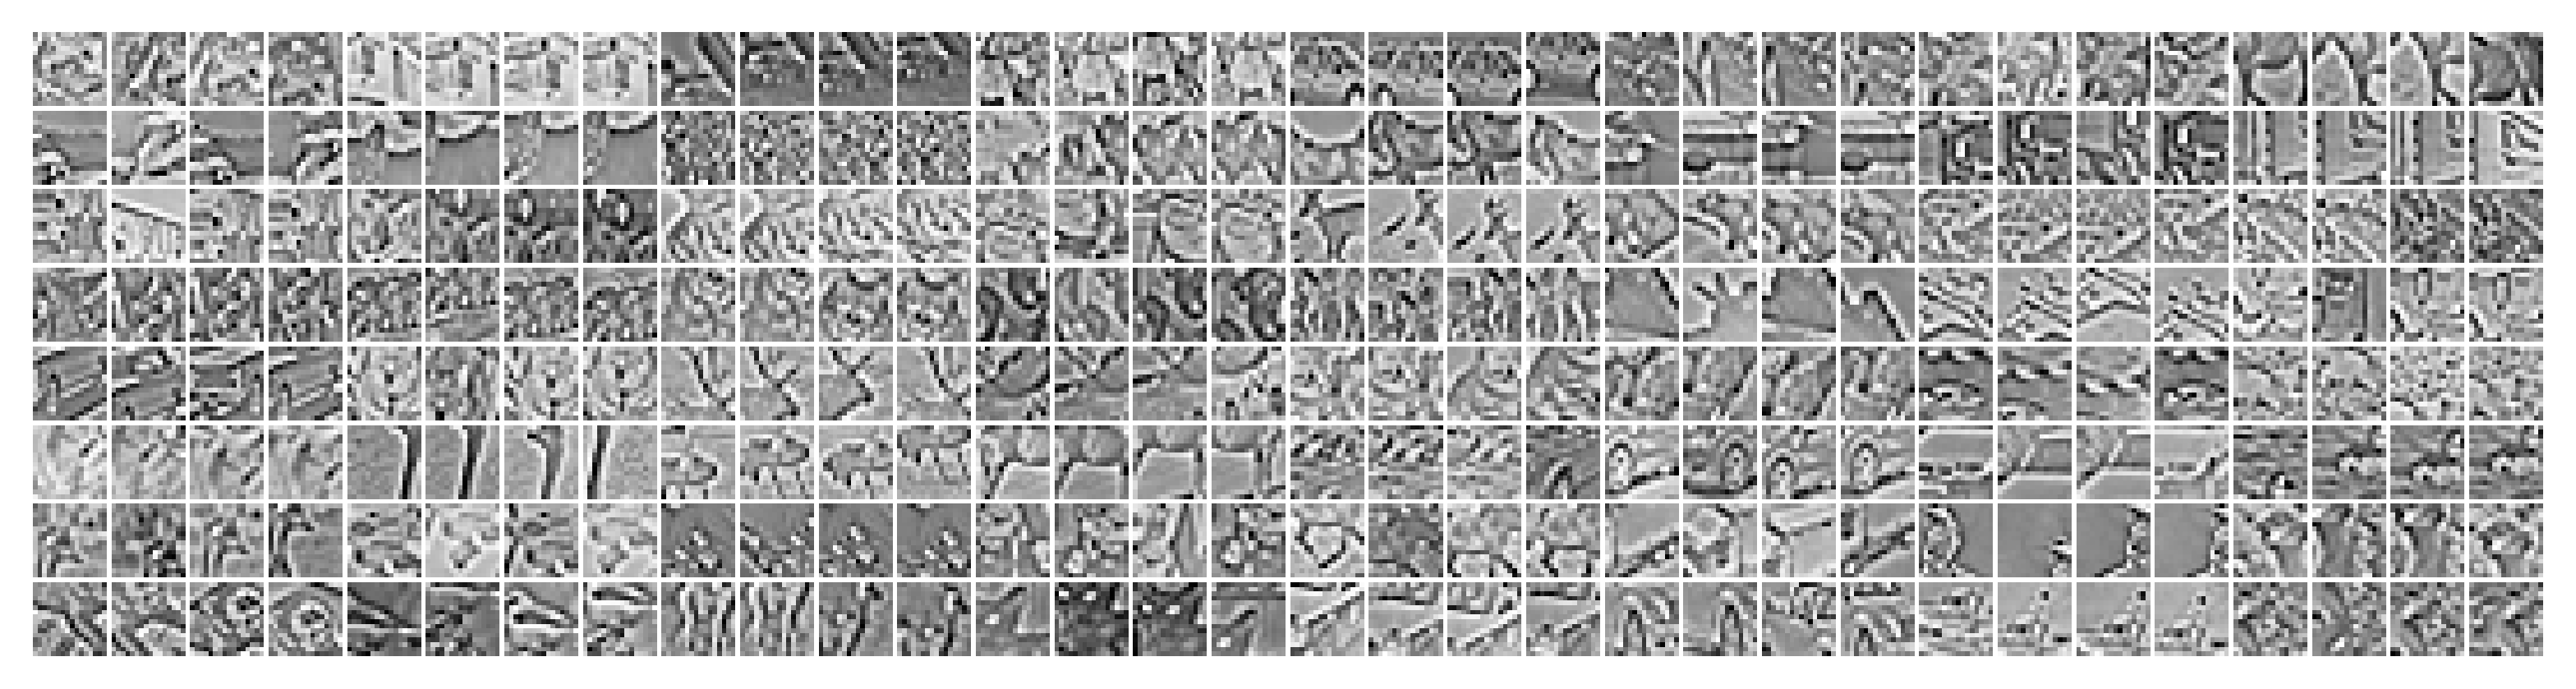

In [14]:
_ = plot_weights(trn.tensors[0][:256], nrows=8, dpi=400)

## Quick comparison to DOVES

In [15]:
trn, vld = make_dataset(
    dataset='DOVES',
    load_dir='/home/hadi/Datasets',
    device=torch.device('cuda:0'),
)

In [16]:
trn.tensors[0].shape

torch.Size([107520, 1, 16, 16])

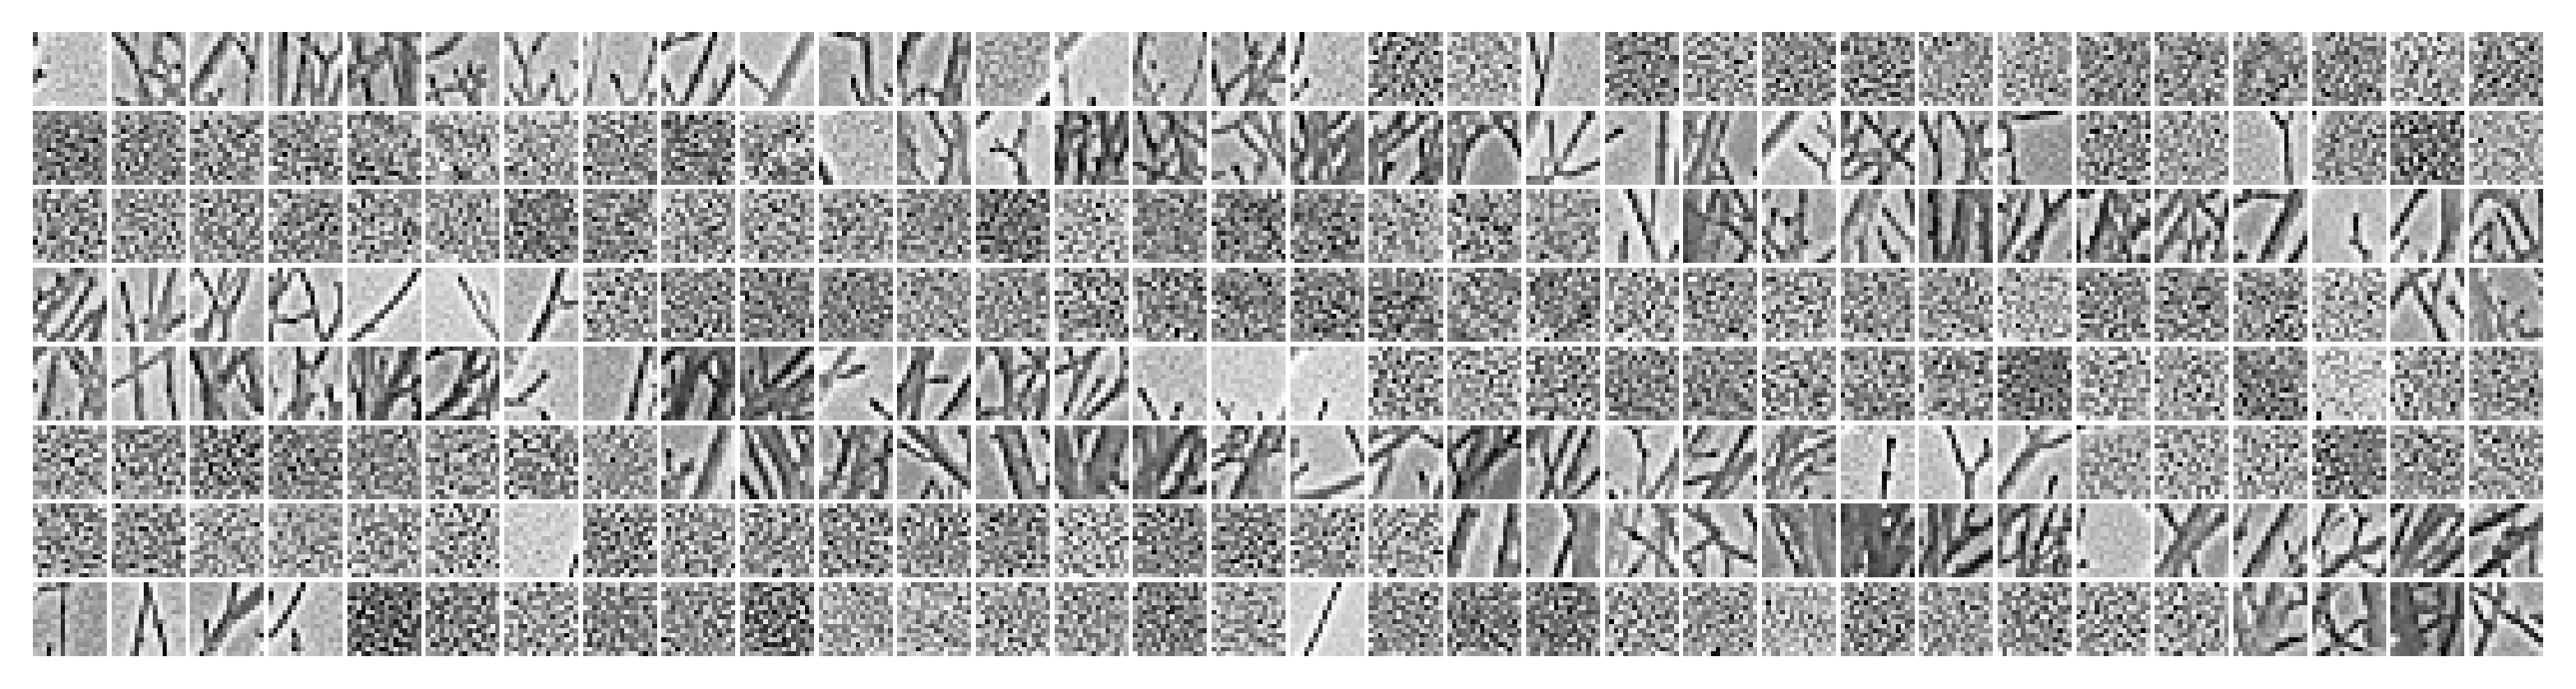

In [17]:
_ = plot_weights(trn.tensors[0][:256], nrows=8, dpi=400)

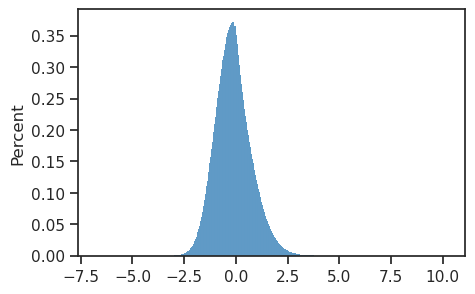

In [18]:
sns.histplot(to_np(trn.tensors[0]).ravel(), stat='percent');